## Imports

In [0]:
# Python Print
from __future__ import print_function

In [0]:
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# Image Loader and Display
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [0]:
# Model Train/Load/Copy etc
import torchvision.models as models
import copy
import os
import datetime

In [0]:
# Ignore ipykernel warnings
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [0]:
# GPU Settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Data Loading

### Helper functions for images

In [0]:
# image sizes: use smaller one if on CPU
imsize = 512 if torch.cuda.is_available() else 128

In [0]:
# image loader function
def image_loader(img_name):
  image = Image.open(img_name)
  loader = transforms.Compose([transforms.Resize(imsize),transforms.ToTensor()])
  image_tensor = loader(image).unsqueeze(0)
  return image_tensor.to(device, torch.float)

In [0]:
# image display or save
def image_show(img_tensor, title=None,save_fig=False):
  image = img_tensor.cpu().clone()
  image = image.squeeze(0)
  image = (transforms.ToPILImage())(image)
  img_title = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") if (title is None) else title
  plt.imshow(image)
  plt.axis('off')
  plt.title(img_title)
  if save_fig:
    plt.savefig("plots/{}.png".format(img_title))

### A Pair of Stylier Image and Content Image

In [0]:
# # A style image and a content image
# stylier_img = image_loader("img_data/Antoine_Watteau-L'imbarco_per_Citera.jpg")
# content_img = image_loader("img_data/tea-3190241.jpg")

# assert stylier_img.size() == content_img.size(), "stylier image and content image should of same size"

In [0]:
# # Look at the loaded images
# plt.ion()
# plt.figure()
# image_show(stylier_img,"Antoine_Watteau - styler",save_fig=True)
# plt.figure()
# image_show(content_img,save_fig=True)

## Build the Model

### Loss Function

MSE for content loss

In [0]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    # we 'detach' the target content from the tree used
    # to dynamically compute the gradient: this is a stated value,
    # not a variable. Otherwise the forward method of the criterion
    # will throw an error.
    self.target = target.detach()
  
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    #self.loss = F.binary_cross_entropy_with_logits(input, self.target)
    return input  

MSE for styler loss (need to use Gram matrix)

In [0]:
def gram_matrix(input):
  a,b,c,d = input.size()  #a=batchsize, b=n_featuremaps, cxd=dimesnion of a feature map
  features = input.view(a*b, c*d)
  gram = torch.mm(features, features.t())
  return gram.div(a*b*c*d)

class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

### Transfer Learning with Pre-Trained VGG19

### Pre-Trained VGG19 from Torch Models

Note that we only need the "feature" part, which includes all the CNNs and Pools. Just kick away the "classifier" part, which contains MLP and classifiers

Also, need to normalize the images as in VGG19 training. Read the doc, we know it is using: mean = (0.485, 0.456, 0.406) and std dev = (0.229, 0.224, 0.225)

In [0]:
# cnn_vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

# vgg19_norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
# vgg19_norm_stdev = torch.tensor([0.229, 0.224, 0.225]).to(device)

class vgg19_normalization(nn.Module):
  def __init__(self, mean, std):
    super(vgg19_normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1,1,1)
    self.std = torch.tensor(std).view(-1,1,1)
  
  def forward(self, img):
    return (img - self.mean) / self.std

### Build the Network

Just add loss layers after the vgg19 features 

In [0]:
def get_style_model_and_losses(pretrained_cnn, normal_mean, normal_stdev,
                               stylier_img, content_img,
                               stylier_layer=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
                               content_layer=['conv_4']):
  cnn = copy.deepcopy(pretrained_cnn)
  normalization = vgg19_normalization(normal_mean,normal_stdev).to(device)

  stylier_loss, content_loss = [], []

  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    # check if the layer is conv/relu/pool/batchnorm
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    
    model.add_module(name, layer)

    if name in content_layer: # add content loss if is in content layers
      target = model(content_img).detach()
      c_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), c_loss)
      content_loss.append(c_loss)
    
    if name in stylier_layer:
      target = model(stylier_img).detach()
      s_loss = StyleLoss(target)
      model.add_module("stylier_loss_{}".format(i), s_loss)
      stylier_loss.append(s_loss)
    
  # Trim the layers after the last content/style losses
  for i in range(len(model)-1, -1, -1):
    if isinstance(model[i],ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[:(i+1)]

  return model, stylier_loss, content_loss

### Optimizer

Use LBFGS, a "flavored" version of gradient descent.

In [0]:
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

## Train the Model

### Define the training function

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=600,
                       style_weight=1000000, content_weight=1,verbose=True):
    if verbose:
      print("Building the model......")
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    if verbose:
      # print(model)
      print("Optimizing......")
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            run[0] += 1
            if verbose and run[0] % 50 == 0:
                print("run {}: Style Loss : {:4f} Content Loss: {:4f}".format(run,style_score.item(), content_score.item()))

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [0]:
# input_img = content_img.clone()
# output = run_style_transfer(cnn_vgg19,vgg19_norm_mean,vgg19_norm_stdev, content_img, stylier_img, input_img,num_steps=800)
# image_show(output)

## Runing Experiments

In [19]:
print("working on {}".format(device))
print("working with images of size {}".format(imsize))

working on cuda
working with images of size 512


In [0]:
content_names = ["tea","lilypond","bouquet","ballerina"]
stylier_names = ["Monet","VanGogh","Renoir","Degas"]
painted_results = []

In [0]:
cnn_vgg19 = models.vgg19(pretrained=True).features.to(device).eval()
vgg19_norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg19_norm_stdev = torch.tensor([0.229, 0.224, 0.225]).to(device)


********************************
using tea as content iamge and Monet as stylier

500 steps with 1 content weight and 500000 style weight

Building the model......
Optimizing......
run [50]: Style Loss : 0.000034 Content Loss: 6.913684
run [100]: Style Loss : 0.000014 Content Loss: 5.737328
run [150]: Style Loss : 0.000004 Content Loss: 4.762864
run [200]: Style Loss : 0.000002 Content Loss: 4.137714
run [250]: Style Loss : 0.000001 Content Loss: 3.805650
run [300]: Style Loss : 0.000001 Content Loss: 3.614213
run [350]: Style Loss : 0.000001 Content Loss: 3.512686
run [400]: Style Loss : 0.000001 Content Loss: 3.451936
run [450]: Style Loss : 0.000001 Content Loss: 3.405229
run [500]: Style Loss : 0.000001 Content Loss: 3.373956

********************************
using lilypond as content iamge and VanGogh as stylier

500 steps with 1 content weight and 500000 style weight

Building the model......
Optimizing......
run [50]: Style Loss : 0.000073 Content Loss: 20.969671
run [100]: Sty

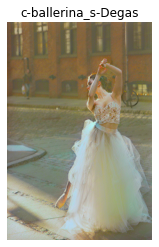

In [22]:
for c_name, s_name in zip(content_names, stylier_names):
  print("\n********************************\nusing {} as content iamge and {} as stylier\n".format(c_name, s_name))
  c_img = image_loader("img_data/{}.jpg".format(c_name))
  s_img = image_loader("img_data/{}.jpg".format(s_name))
  assert c_img.size() == s_img.size(), "content image {} and stylier image {} should be of same size".format(c_img.size(), s_img.size())
  i_img = c_img.clone()
  n_steps=500
  c_weight =1
  s_weight =500000
  print("{} steps with {} content weight and {} style weight\n".format(n_steps, c_weight, s_weight))
  painted_img = run_style_transfer(cnn_vgg19,vgg19_norm_mean,vgg19_norm_stdev,c_img, s_img, i_img,
                                   num_steps=n_steps,style_weight=s_weight, content_weight=c_weight,verbose=True)
  image_show(painted_img, title="c-{}_s-{}".format(c_name,s_name),save_fig=True)